## Network-based collective emotion model

Current needs:
- better matrix of interactions
- matrix of amplitudes of arousal
- probably make those matrices a matrix of vectors ^
- incorporating collective state to informing agent states
- improving stimulation framework
- differentiating social stimulations based on directed weights
- updating directed weights between agents
- improving understanding of network structure with distances between agents
- updating which ties between agents do and do not exist

MAJOR ERRORS:
- dimensional analysis is completely off right now
- uniform random variables are clearly not appropriate for all things
- edges shouldn't necessarily exist between all pairs of agents and strength of ties probably shouldn't be randomly distributed unless updating is allowed

### Packages

In [12]:
# import packages

import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
# import simpy as sim

### Paramters, Pre-Defined Lists, and Helpers

In [54]:
# Define global paramters

n_iterations = 2 # number of simulations
n_agents = 200 # number of agent nodes
n_stimulations = 10 # number of stimulations in whole model equal to number of agents
activation_coeff = 0.7 # coefficient of activation threshold relative to initial arousal amplitude
adaptation_coeff = 0.7 # coefficient of adaptation of agent to stimulus
adaptation_boundary = 3 # number of time steps without stimulus before an agent decreases adaptation
recharge_coeff = 0.3 # coefficient of recharge boundary of agent to stimulus
decay_coeff = .5 # coefficient of decay for agent arousal
arousal_amplitude = 20 # starting amplitude of agent arousal after stimulus, before adaptation

# Define interaction weights matrix

agent_ids = np.arange(1, n_agents + 1) # list of agent ids from 1 to N + 1
initial_weights_matrix = np.zeros((n_agents, n_agents)) # matrix of zeros
interaction_weights_matrix = pd.DataFrame(initial_weights_matrix, columns = agent_ids, index = agent_ids)

# Define edges of network based on initial interaction weights?

edge_list = []
for a in agent_ids: # rows
    for b in agent_ids: # cols
        e = (a, b, interaction_weights_matrix[a][b]) # directed weight from a to b?
        edge_list.append(e)

            
# Handling time course and steps of stimulations

total_time = 10 # total time
dt = 0.1 # time interval
n_time_steps = int(round(total_time / dt)) # number of time steps

stimulations = np.random.randint(0, n_time_steps, n_stimulations)

### Agent Defintions and Methods

We define the temporally dependent activation $a_i(t)$ of an agent $i$ by the following piecewise definition:

$$a_i(t) =
  \begin{cases}
      1 & \text{if $A_i(t) > T_{a_i}$} \\
      0 & \text{otherwise}
  \end{cases}
$$

We denote the arousal state of agent $i$ by $A_i$, and the activation threshold $T_{a_i}$.

In [4]:
# Agent class

class Agent():
        
    def __init__(self, 
                 _id, 
                 arousal_amplitude,
                 adaptation_coeff,
                 activation_coeff, 
                 recharge_coeff, 
                 decay_coeff,
                 n_steps,
                 dt):
        self._id = _id
        self.amplitude = arousal_amplitude * np.random.random_sample()
        self.theta = 1.0 # weighting parameter for solution to exponential diff eq
        self.dt = float(dt)
        self.adaptation_coeff = adaptation_coeff
        self.adaptation_boundary = adaptation_boundary
        self.activation_threshold = activation_coeff * self.amplitude
        self.recharge_threshold = recharge_coeff * self.amplitude
        self.decay = decay_coeff
        
        self.recent_stimulations = 0 # count of recent stimulations, behaves as adaptation multiplier
        self.last_stimulation = 0 # most recent stimulation time
        self.recent_interactions = 0
        self.last_interaction = 0
        
        self.states = np.zeros(int(n_steps) + 1)
        self.states[0] = 0
    
    # stimulate agent, give arousal relative to amplitude and adaptation from previous times
    def stimulation(self, step, stimulus_weight):
        habituation_weight = 0.3 * self.recent_interactions + 0.1 * self.recent_stimulations #arbitrary proportionality
        self.states[step] = stimulus_weight * self.amplitude * np.power(self.adaptation_coeff, habituation_weight) # height of excitation
        
        # increment number of recent stimulations in memory, reset last time of stimulation
        self.recent_stimulations += 1
        self.last_stimulation = step
    
    def interaction(self, step, interaction_weight):
        habituation_weight = 0.3 * self.recent_interactions + 0.1 * self.recent_stimulations #arbitrary proportionality
        self.states[step] = interaction_weight * self.amplitude * np.power(self.adaptation_coeff, habituation_weight) # height of excitation
        
        # increment number of recent interactions in memory, reset last time of interaction
        self.recent_interactions += 1
        self.last_interaction = step

    # Boolean `is_expressing`
    # Returns true if agent is above activation threshold  
    def is_expressing(self, step):
        if self.states[step] > self.activation_threshold:
            return True
        else:
            return False
        
    # Boolean `is_rechargeable`
    # Returns true if agent is above recharge threshold
    # Should depend on weight of interaction/stimulus
    def is_rechargeable(self, step):
        if self.states[step] > self.recharge_threshold:
            return True
        else:
            return False
    
    def decay_factor(self):
        return (1 - (1 - self.theta) * self.decay * self.dt)/(1 + self.theta * self.decay * self.dt)
    
    def update(self, step):
        self.states[step + 1] = self.decay_factor() * self.states[step]
        
        # if it's been at least some steps since a stimulation, decrease adaptation multiplier
        if (step - self.last_stimulation > self.adaptation_boundary) & (self.recent_stimulations > 0):
            self.recent_stimulations -= 1
            
        # if it's been at least some steps since an interaction, decrease adaptation multiplier
        if (step - self.last_interaction > self.adaptation_boundary) & (self.recent_interactions > 0):
            self.recent_interactions -= 1

### Group Definitions and Methods
The following class defines the group model and informs the collective state of our system.

Some notes for the current work:
- Stimulation times are randomly assigned throughout the time steps to a single agent at that time
- The graph is a complete, directed graph with weights between agents sampled from the standard normal distribution for each direction

In [5]:
# Group class

class Group():
    
    def __init__(self, n_agents, n_steps, dt, stimulations, edge_list):
        self.n_agents = n_agents
        self.n_steps = n_steps
        self.dt = dt
        self.n_stimulations = n_stimulations
        
        # Randomly assign stimulation times
        self.stimulations = stimulations
        self.edge_list = edge_list # list of edges for network structure
        self.graph = nx.DiGraph() # network structure
        
        self.agents = {} # dictionary of agents
        self.agents_state_history = [] # records of states of agents over time
        self.collective_state_history = [] # records of states of collective
    
    # populate group's agent dictionary and network, including edges
    def populate(self):
        for i in range(self.n_agents):
            
            # instantiate agent object and assign to a
            a = Agent(i, 
                      arousal_amplitude, 
                      adaptation_coeff, 
                      activation_coeff, 
                      recharge_coeff, 
                      decay_coeff,
                      self.n_steps,
                      self.dt
                     )
            
            # add key-value pair of _id and agent object
            self.agents[i] = a
            
            # add agent's _id as a node
            self.graph.add_node(i) 
        
        # add edges from list with initial weights for tie strength
        self.graph.add_weighted_edges_from(edge_list)
    
    def stimulate_single_random_agent(self, step, weight):
        # list of agent ids in graph
        agent_ids = [n for n in group.graph.nodes()]
        
        # sample for single _id to stimulate at t_current
        sampling_ids = np.random.choice(agent_ids, 3)
        
        # stimulate the given _id
        for _id in sampling_ids:
            self.agents[_id].stimulation(step, weight)
    
    # interaction between two agents a and b
    def interact(self, a, b, step, weight):
        # print([a._id, b._id], "are interacting at time", t_current)
        if b.is_rechargeable(step):
            # print('agent', a._id, 'recharges agent', b._id)
            b.interaction(step, weight)
    
    # update agent states across group's network
    def update(self, step):
                
        # empty list for current list of states at current step
        current_states = []
        current_expressors = []
        current_interactions = []
        
        # randomly stimulate single agent if t_current is in the assigned stimulant list        
        for s in self.stimulations:
            stimulus_weight = np.random.random_sample() #stimulus weight if stimulus at this point in time
            if s == step:
                self.stimulate_single_random_agent(s, stimulus_weight)
        
        # iterate through agents; if expressing emotion, interact with neighbors
        interaction_weights = nx.get_edge_attributes(self.graph, 'weight') # weights matrix from edge list, will need to update this for practical model
        for node_id in self.graph:
            a = self.agents[node_id]
            if a.is_expressing(step):
                current_expressors.append(a.states[step]) # append agent's arousal state to current expressors list
                for neighbor_id in nx.all_neighbors(self.graph, node_id):
                    b = self.agents[neighbor_id]
                    directed_weight_a_to_b = interaction_weights[(a._id, b._id)]
                    # print(directed_weight)
                    self.interact(a, b, step, directed_weight_a_to_b)
                    
                    current_interactions.append()
                    
            self.agents[node_id].update(step)
            current_states.append(self.agents[node_id].states[step])
            
            
            # TODO: update interactions and weights and such based on previous states and collective state
         
        # history of states updated for collective and individual agent lists
        collective_state = len(current_expressors) / n_agents # ratio of currently expressing agents
        
        self.collective_state_history.append(collective_state)
        self.agents_state_history.append(current_states)

### Simulation

In [6]:
# run model for n_iterations
simulations = []
for iters in range(n_iterations):
    
    dt = float(dt) # float value
    n_steps = int(round(total_time / dt))
    total_time = n_time_steps * dt # adjust to be float
    time_list = np.linspace(0, total_time, n_time_steps + 1) # list of time values, useful for analysis
    
    group = Group(n_agents, n_steps, dt, stimulations, edge_list)
    group.populate()
    
    for step in range(0, n_time_steps):
        group.update(step)
    simulations.append(group.collective_state_history)

### Results

Plot for 2 simulations with 10 equally timed stimulations per run and 200 agents


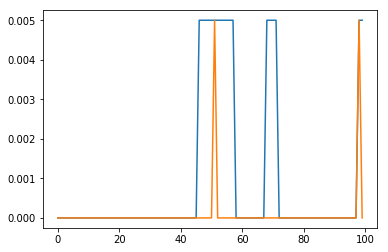

In [7]:
print("Plot for", len(simulations), "simulations with", len(stimulations), "equally timed stimulations per run and", n_agents, "agents")
for s in range(len(simulations)):
    plt.plot(simulations[s])

Notes:
- define recharge boundary as a probabilistic function dependent on weight of stimulus
- define how internal stimuli (interaction) elicit an agent's arousal
- number of neighbors expressing emotion affects/influences the arousal of a given agent
- a stronger emotion should be more likely to excite another agent than a weaker emotion
- is activation threshold correlated to sensitivity (amplitude) of a person to a stimulus or is it orthogonal to the amplitude
    - activation threshold is some number between 0 and the unhabituated amplitude of a person's arousal
- amplitude should be different for every person